# Importing required libraries

In [1]:
import matplotlib
import pandas as pd
import numpy as np
import math
from numpy import argmax
import sys
from IPython.display import display
import warnings
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import callbacks

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
import numpy as np
import time
import statistics


# library options
%matplotlib inline
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

In [2]:
# Monte Carlo Dropout Layer
class MonteCarloDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

# Read in the Train and Test data

In [3]:
X_train = np.array(pd.read_parquet('data/X_train.parquet').drop(['sum_day_1','sum_day_2','sum_day_3','gradient','clumpiness'], axis=1)).astype('float')
X_test = np.array(pd.read_parquet('data/X_test.parquet').drop(['sum_day_1','sum_day_2','sum_day_3','gradient','clumpiness'], axis=1)).astype('float')

y_test_class = np.array(pd.read_parquet('data/y_test.parquet')['sum_payments_package_key_ltv_class'])
y_train_class = np.array(pd.read_parquet('data/y_train.parquet')['sum_payments_package_key_ltv_class'])                        
#y_test_class = np.array(pd.read_parquet('data/y_test.parquet')['sum_payments_package_key_ltv_class'].apply(lambda x: 0 if x == 'low' else 1 if x == "medium" else 2 if x == "high" else -1)).astype('float')
#y_train_class = np.array(pd.read_parquet('data/y_train.parquet')['sum_payments_package_key_ltv_class'].apply(lambda x: 0 if x == 'low' else 1 if x == "medium" else 2 if x == "high" else -1)).astype('float')
y_test_reg = np.array(pd.read_parquet('data/y_test.parquet')['sum_payments_package_key_ltv']).astype('float')
y_train_reg = np.array(pd.read_parquet('data/y_train.parquet')['sum_payments_package_key_ltv']).astype('float')
n_class = 3

# Check Data before Modelling 

In [4]:
print('Training Features Shape:', X_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Training Labels Classification Shape:', y_train_class.shape)
print('Testing Labels Classification Shape:', y_test_class.shape)

Training Features Shape: (111791, 175)
Testing Features Shape: (27948, 175)
Training Labels Classification Shape: (111791,)
Testing Labels Classification Shape: (27948,)


# Hyperparameter Tuning

In [5]:
def model_builder(hp):
    model = keras.Sequential()

    # layer 01
    layer_01 = hp.Choice('layer_01', values = ['False','True'])
    if layer_01:
        units_01 = hp.Int('units_01', min_value=64, max_value=1024, step=32)
        activation_01 = hp.Choice('activation_01', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_01 = hp.Choice('kernel_01', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_01, activation = activation_01, kernel_initializer=kernel_initializer_01, input_shape = (X_train.shape[1],)))
    
    batch_01 = hp.Choice('batch_01', values = ['False','True'])
    if batch_01:
        model.add(BatchNormalization())
    
    drop_01 = hp.Choice('drop_01', values = ['False','drop','Monte'])
    if drop_01 == 'drop':
        dropout_01 = hp.Float('dropout_01', min_value=0.1, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_01))
    elif drop_01 == 'Monte':
        monte_01 = hp.Float('monte_01', min_value=0.1, max_value=0.6, step=0.1)
        model.add(MonteCarloDropout(monte_01))
    
    # layer 02
    layer_02 = hp.Choice('layer_02', values = ['False','True'])
    if layer_02:
        units_02 = hp.Int('units_02', min_value = 32, max_value = 512, step=32)
        activation_02 = hp.Choice('activation_02', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_02 = hp.Choice('kernel_02', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_02, activation = activation_02, kernel_initializer=kernel_initializer_02))
    
    batch_02 = hp.Choice('batch_02', values = ['False','True'])
    if batch_02:
        model.add(BatchNormalization())
        
    drop_02 = hp.Choice('drop_02', values = ['False','drop','Monte'])
    if drop_02:
        dropout_02 = hp.Float('dropout_02', min_value=0.1, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_02))
    elif drop_02 == 'Monte':
        monte_02 = hp.Float('monte_02', min_value=0.1, max_value=0.6, step=0.1)
        model.add(MonteCarloDropout(monte_02))
    
    # layer 03
    layer_03 = hp.Choice('layer_03', values = ['False','True'])
    if layer_03:
        units_03 = hp.Int('units_03', min_value = 32, max_value = 512, step=32)
        activation_03 = hp.Choice('activation_03', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_03 = hp.Choice('kernel_03', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_03, activation = activation_03, kernel_initializer=kernel_initializer_03))
    
    drop_03 = hp.Choice('drop_03', values = ['False','drop','Monte'])
    if drop_03:
        dropout_03 = hp.Float('dropout_03', min_value=0.1, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_03))
    elif drop_03 == 'Monte':
        monte_03 = hp.Float('monte_03', min_value=0.1, max_value=0.6, step=0.1)
        model.add(MonteCarloDropout(monte_03))
    
    batch_03 = hp.Choice('batch_03', values = ['False','True'])
    if batch_03:
        model.add(BatchNormalization())
    
    # layer 04
    layer_04 = hp.Choice('layer_04', values = ['False','True'])
    if layer_04:
        units_04 = hp.Int('units_04', min_value = 16, max_value = 512, step=32)
        activation_04 = hp.Choice('activation_04', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_04 = hp.Choice('kernel_04', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_04, activation = activation_04, kernel_initializer=kernel_initializer_04))
    
    drop_04 = hp.Choice('drop_04', values = ['False','drop','Monte'])
    if drop_04:
        dropout_04 = hp.Float('dropout_04', min_value=0.1, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_04))
    elif drop_04 == 'Monte':
        monte_04 = hp.Float('monte_04', min_value=0.1, max_value=0.6, step=0.1)
        model.add(MonteCarloDropout(monte_04))
        
    batch_04 = hp.Choice('batch_04', values = ['False','True'])
    if batch_04:
        model.add(BatchNormalization())
    
    # layer 05
    layer_05 = hp.Choice('layer_05', values = ['False','True'])
    if layer_05:
        units_05 = hp.Int('units_05', min_value = 16, max_value = 256, step=32)
        activation_05 = hp.Choice('activation_05', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_05 = hp.Choice('kernel_05', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_05, activation = activation_05, kernel_initializer=kernel_initializer_05))
    
    drop_05 = hp.Choice('drop_05', values = ['False','drop','Monte'])
    if drop_05:
        dropout_05 = hp.Float('dropout_05', min_value=0.1, max_value=0.6, step=0.1)
        model.add(Dropout(dropout_05))
    elif drop_05 == 'Monte':
        monte_05 = hp.Float('monte_05', min_value=0.1, max_value=0.6, step=0.1)
        model.add(MonteCarloDropout(monte_05))
        
    batch_05 = hp.Choice('batch_05', values = ['False','True'])
    if batch_05:
        model.add(BatchNormalization())
    
    # layer 06
    layer_06 = hp.Choice('layer_06', values = ['False','True'])
    if layer_06:
        units_06 = hp.Int('units_06', min_value = 4, max_value = 16, step=4)
        activation_06 = hp.Choice('activation_06', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_06 = hp.Choice('kernel_06', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_06, activation = activation_06, kernel_initializer=kernel_initializer_06))
        
    # layer 07
    layer_07 = hp.Choice('layer_07', values = ['False','True'])
    if layer_07:
        units_07 = hp.Int('units_07', min_value = 4, max_value = 16, step=4)
        activation_07 = hp.Choice('activation_07', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_07 = hp.Choice('kernel_07', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_07, activation = activation_07, kernel_initializer=kernel_initializer_07))    
    
    # layer 08
    layer_08 = hp.Choice('layer_08', values = ['False','True'])
    if layer_08:
        units_08 = hp.Int('units_08', min_value = 4, max_value = 16, step=4)
        activation_08 = hp.Choice('activation_08', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_08 = hp.Choice('kernel_08', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_08, activation = activation_08, kernel_initializer=kernel_initializer_08))
        
    # layer 09
    layer_09 = hp.Choice('layer_06', values = ['False','True'])
    if layer_09:
        units_09 = hp.Int('units_06', min_value = 4, max_value = 16, step=4)
        activation_09 = hp.Choice('activation_09', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_09 = hp.Choice('kernel_09', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_09, activation = activation_09, kernel_initializer=kernel_initializer_09))
        
    # layer 10
    layer_10 = hp.Choice('layer_10', values = ['False','True'])
    if layer_10:
        units_10 = hp.Int('units_10', min_value = 4, max_value = 16, step=4)
        activation_10 = hp.Choice('activation_10', values = ['LeakyReLU','relu','sigmoid','tanh'])
        kernel_initializer_10 = hp.Choice('kernel_10', values = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal'])
        model.add(Dense(units_10, activation = activation_10, kernel_initializer=kernel_initializer_10))
    
    model.add(Dense(n_class, activation='softmax'))
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_crossentropy','accuracy'])

    return model

In [6]:
# Select Tuner Hyperband
tuner = kt.Hyperband(model_builder,
                     objective = 'sparse_categorical_crossentropy',
                     max_epochs = 40,
                     factor = 6,
                     project_name = 'MLP_Classification_withoutTA_04')

stop_early = callbacks.EarlyStopping(monitor='accuracy', patience=7)

In [7]:
tuner.search(X_train, y_train_class, epochs=100, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print('The hyperparameter search is complete. The optimal model is:')
print(best_hps)

Trial 76 Complete [00h 08m 42s]
sparse_categorical_crossentropy: 0.5287711024284363

Best sparse_categorical_crossentropy So Far: 0.32398948073387146
Total elapsed time: 02h 16m 58s
INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete. The optimal model is:


In [8]:
tuner.results_summary()

Results summary
Results in ./MLP_Classification_withoutTA_04
Showing 10 best trials
Objective(name='sparse_categorical_crossentropy', direction='min')
Trial summary
Hyperparameters:
layer_01: True
units_01: 288
activation_01: tanh
kernel_01: he_uniform
batch_01: True
drop_01: False
layer_02: False
units_02: 352
activation_02: LeakyReLU
kernel_02: he_normal
batch_02: False
drop_02: Monte
dropout_02: 0.1
layer_03: False
units_03: 416
activation_03: LeakyReLU
kernel_03: glorot_normal
drop_03: False
dropout_03: 0.1
batch_03: True
layer_04: True
units_04: 496
activation_04: sigmoid
kernel_04: glorot_uniform
drop_04: Monte
dropout_04: 0.30000000000000004
batch_04: True
layer_05: False
units_05: 176
activation_05: LeakyReLU
kernel_05: glorot_normal
drop_05: False
dropout_05: 0.30000000000000004
batch_05: True
layer_06: True
units_06: 8
activation_06: tanh
kernel_06: glorot_uniform
layer_07: False
units_07: 8
activation_07: sigmoid
kernel_07: glorot_uniform
layer_08: True
units_08: 12
activati

drop_04: Monte
dropout_04: 0.30000000000000004
batch_04: True
layer_05: False
units_05: 176
activation_05: LeakyReLU
kernel_05: glorot_normal
drop_05: False
dropout_05: 0.30000000000000004
batch_05: True
layer_06: True
units_06: 8
activation_06: tanh
kernel_06: glorot_uniform
layer_07: False
units_07: 8
activation_07: sigmoid
kernel_07: glorot_uniform
layer_08: True
units_08: 12
activation_08: LeakyReLU
kernel_08: glorot_normal
activation_09: LeakyReLU
kernel_09: glorot_normal
layer_10: False
units_10: 4
activation_10: LeakyReLU
kernel_10: glorot_normal
learning_rate: 0.001
monte_01: 0.2
dropout_01: 0.2
tuner/epochs: 7
tuner/initial_epoch: 2
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 91312d70470fae80d47b180cfa587486
Score: 0.4157620966434479
Trial summary
Hyperparameters:
layer_01: False
units_01: 544
activation_01: sigmoid
kernel_01: he_normal
batch_01: False
drop_01: Monte
layer_02: True
units_02: 288
activation_02: tanh
kernel_02: he_normal
batch_02: True
drop_02: Monte
dropout

In [9]:
# Build the model with the optimal hyperparameters and train it on the data for 100 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train_class, validation_split=0.33, epochs = 100)

Epoch 1/100
2341/2341 [==============================] - 15s 6ms/step - loss: 0.6341 - sparse_categorical_crossentropy: 0.6341 - accuracy: 0.7241 - val_loss: 0.4629 - val_sparse_categorical_crossentropy: 0.4629 - val_accuracy: 0.8193
Epoch 2/100
2341/2341 [==============================] - 15s 6ms/step - loss: 0.5007 - sparse_categorical_crossentropy: 0.5007 - accuracy: 0.7997 - val_loss: 0.4340 - val_sparse_categorical_crossentropy: 0.4340 - val_accuracy: 0.8238
Epoch 3/100
2341/2341 [==============================] - 14s 6ms/step - loss: 0.4743 - sparse_categorical_crossentropy: 0.4743 - accuracy: 0.8123 - val_loss: 0.4343 - val_sparse_categorical_crossentropy: 0.4343 - val_accuracy: 0.8082
Epoch 4/100
2341/2341 [==============================] - 15s 6ms/step - loss: 0.4605 - sparse_categorical_crossentropy: 0.4605 - accuracy: 0.8176 - val_loss: 0.4317 - val_sparse_categorical_crossentropy: 0.4317 - val_accuracy: 0.8257
Epoch 5/100
2341/2341 [==============================] - 14s 6ms

Epoch 36/100
2341/2341 [==============================] - 14s 6ms/step - loss: 0.3077 - sparse_categorical_crossentropy: 0.3077 - accuracy: 0.8805 - val_loss: 0.4654 - val_sparse_categorical_crossentropy: 0.4654 - val_accuracy: 0.8253
Epoch 37/100
2341/2341 [==============================] - 14s 6ms/step - loss: 0.3063 - sparse_categorical_crossentropy: 0.3063 - accuracy: 0.8808 - val_loss: 0.4587 - val_sparse_categorical_crossentropy: 0.4587 - val_accuracy: 0.8212
Epoch 38/100
2341/2341 [==============================] - 14s 6ms/step - loss: 0.3017 - sparse_categorical_crossentropy: 0.3017 - accuracy: 0.8823 - val_loss: 0.4735 - val_sparse_categorical_crossentropy: 0.4735 - val_accuracy: 0.8399
Epoch 39/100
2341/2341 [==============================] - 14s 6ms/step - loss: 0.2964 - sparse_categorical_crossentropy: 0.2964 - accuracy: 0.8854 - val_loss: 0.4496 - val_sparse_categorical_crossentropy: 0.4496 - val_accuracy: 0.8362
Epoch 40/100
2341/2341 [==============================] - 14

Epoch 71/100
2341/2341 [==============================] - 14s 6ms/step - loss: 0.2029 - sparse_categorical_crossentropy: 0.2029 - accuracy: 0.9251 - val_loss: 0.6351 - val_sparse_categorical_crossentropy: 0.6351 - val_accuracy: 0.8060
Epoch 72/100
2341/2341 [==============================] - 14s 6ms/step - loss: 0.2024 - sparse_categorical_crossentropy: 0.2024 - accuracy: 0.9253 - val_loss: 0.6414 - val_sparse_categorical_crossentropy: 0.6414 - val_accuracy: 0.8204
Epoch 73/100
2341/2341 [==============================] - 15s 6ms/step - loss: 0.2023 - sparse_categorical_crossentropy: 0.2023 - accuracy: 0.9258 - val_loss: 0.6832 - val_sparse_categorical_crossentropy: 0.6832 - val_accuracy: 0.7708
Epoch 74/100
2341/2341 [==============================] - 14s 6ms/step - loss: 0.1971 - sparse_categorical_crossentropy: 0.1971 - accuracy: 0.9273 - val_loss: 0.7026 - val_sparse_categorical_crossentropy: 0.7026 - val_accuracy: 0.7958
Epoch 75/100
2341/2341 [==============================] - 14

In [10]:
# Select best training epoch with lowest validation loss
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 14


In [23]:
start_time = time.time()
hypermodel = tuner.hypermodel.build(best_hps)
print(str(model),"--- %s seconds ---" % ((time.time() - start_time)))

# Retrain the model
history = hypermodel.fit(X_train, y_train_class,validation_split=0.33, epochs=best_epoch)            

<keras.engine.sequential.Sequential object at 0x7fb50d8a1c40> --- 0.1731569766998291 seconds ---
Epoch 1/100
2341/2341 [==============================] - 16s 6ms/step - loss: 0.6576 - sparse_categorical_crossentropy: 0.6576 - accuracy: 0.7099 - val_loss: 0.4651 - val_sparse_categorical_crossentropy: 0.4651 - val_accuracy: 0.8203
Epoch 2/100
2341/2341 [==============================] - 14s 6ms/step - loss: 0.5110 - sparse_categorical_crossentropy: 0.5110 - accuracy: 0.7986 - val_loss: 0.4777 - val_sparse_categorical_crossentropy: 0.4777 - val_accuracy: 0.8101
Epoch 3/100
2341/2341 [==============================] - 14s 6ms/step - loss: 0.4814 - sparse_categorical_crossentropy: 0.4814 - accuracy: 0.8101 - val_loss: 0.4192 - val_sparse_categorical_crossentropy: 0.4192 - val_accuracy: 0.8354
Epoch 4/100
2341/2341 [==============================] - 18s 8ms/step - loss: 0.4597 - sparse_categorical_crossentropy: 0.4597 - accuracy: 0.8190 - val_loss: 0.4072 - val_sparse_categorical_crossentrop

2341/2341 [==============================] - 16s 7ms/step - loss: 0.3070 - sparse_categorical_crossentropy: 0.3070 - accuracy: 0.8790 - val_loss: 0.4538 - val_sparse_categorical_crossentropy: 0.4538 - val_accuracy: 0.8117
Epoch 36/100
2341/2341 [==============================] - 14s 6ms/step - loss: 0.3058 - sparse_categorical_crossentropy: 0.3058 - accuracy: 0.8798 - val_loss: 0.4429 - val_sparse_categorical_crossentropy: 0.4429 - val_accuracy: 0.8323
Epoch 37/100
2341/2341 [==============================] - 15s 6ms/step - loss: 0.2980 - sparse_categorical_crossentropy: 0.2980 - accuracy: 0.8833 - val_loss: 0.4678 - val_sparse_categorical_crossentropy: 0.4678 - val_accuracy: 0.8355
Epoch 38/100
2341/2341 [==============================] - 15s 6ms/step - loss: 0.2945 - sparse_categorical_crossentropy: 0.2945 - accuracy: 0.8847 - val_loss: 0.4367 - val_sparse_categorical_crossentropy: 0.4367 - val_accuracy: 0.8339
Epoch 39/100
2341/2341 [==============================] - 15s 6ms/step - 

Epoch 70/100
2341/2341 [==============================] - 15s 6ms/step - loss: 0.2001 - sparse_categorical_crossentropy: 0.2001 - accuracy: 0.9255 - val_loss: 0.6428 - val_sparse_categorical_crossentropy: 0.6428 - val_accuracy: 0.7892
Epoch 71/100
2341/2341 [==============================] - 15s 6ms/step - loss: 0.1951 - sparse_categorical_crossentropy: 0.1951 - accuracy: 0.9277 - val_loss: 0.6084 - val_sparse_categorical_crossentropy: 0.6084 - val_accuracy: 0.8226
Epoch 72/100
2341/2341 [==============================] - 15s 6ms/step - loss: 0.1967 - sparse_categorical_crossentropy: 0.1967 - accuracy: 0.9271 - val_loss: 0.6618 - val_sparse_categorical_crossentropy: 0.6618 - val_accuracy: 0.7907
Epoch 73/100
2341/2341 [==============================] - 15s 6ms/step - loss: 0.1925 - sparse_categorical_crossentropy: 0.1925 - accuracy: 0.9292 - val_loss: 0.6140 - val_sparse_categorical_crossentropy: 0.6140 - val_accuracy: 0.8257
Epoch 74/100
2341/2341 [==============================] - 15

## Results

dict_keys(['loss', 'sparse_categorical_crossentropy', 'accuracy', 'val_loss', 'val_sparse_categorical_crossentropy', 'val_accuracy'])


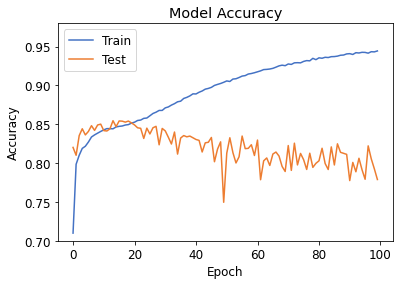

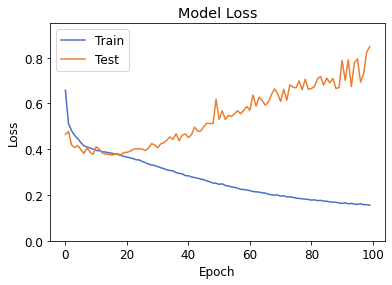

In [24]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'], color = '#4472C4')
plt.plot(history.history['val_accuracy'], color = '#ED7D31')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0.7,0.98)
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('results/DNN_accuracy_Class_withoutTA.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'], color = '#4472C4')
plt.plot(history.history['val_loss'], color = '#ED7D31')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.ylim(0,0.95)
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('results/DNN_loss_Class_withoutTA.png')
plt.show()

F1-Score per Class: [0.90578067 0.83092389 0.79674892]
F1-Score on Micro average (micro calculates positive and negative values globally): 0.8423142979819666
F1-Score on Macro average (average of each class’s F-1 score): 0.8444844917559569
F1-Score on weighted average: 0.8397621333936388
______________________________________________________

              precision    recall  f1-score   support

         Low       0.84      0.99      0.91      7494
      Medium       0.83      0.83      0.83     11267
        High       0.86      0.74      0.80      9187

    accuracy                           0.84     27948
   macro avg       0.84      0.85      0.84     27948
weighted avg       0.84      0.84      0.84     27948



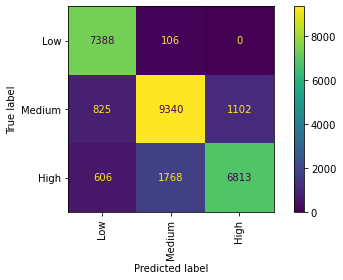

In [13]:
#note in kera model.predict() will return predict probabilities
y_pred =  hypermodel.predict(X_test, verbose=0)

prediction_class = []
for i in range(len(y_pred)):
    if y_pred[i][0] > y_pred[i][1] and y_pred[i][0] > y_pred[i][2]:
        prediction_class.append(0)
    if y_pred[i][1] > y_pred[i][0] and y_pred[i][1] > y_pred[i][2]:
        prediction_class.append(1)
    if y_pred[i][2] > y_pred[i][0] and y_pred[i][2] > y_pred[i][1]:
        prediction_class.append(2)

#f1_score(y_test_class, y_pred, average=None)

prediction_class = np.array(prediction_class)
print("F1-Score per Class: %s" % f1_score(y_test_class, prediction_class, average=None)) 
print("F1-Score on Micro average (micro calculates positive and negative values globally): %s" % f1_score(y_test_class, prediction_class, average='micro')) 
print("F1-Score on Macro average (average of each class’s F-1 score): %s" % f1_score(y_test_class, prediction_class, average='macro')) 
print("F1-Score on weighted average: %s" % f1_score(y_test_class, prediction_class, average='weighted')) 
print('______________________________________________________')
print('')
print(classification_report(y_test_class, prediction_class, target_names=['Low','Medium','High']))

ConfusionMatrixDisplay.from_predictions(y_test_class, prediction_class, display_labels=['Low','Medium','High'], xticks_rotation="vertical")
plt.tight_layout()
plt.savefig('results/DNN_Class_Confusion_withoutTA.png')
plt.show()

In [14]:
cohen_kappa = cohen_kappa_score(y_test_class, prediction_class)
cohen_kappa

0.7612758396541444

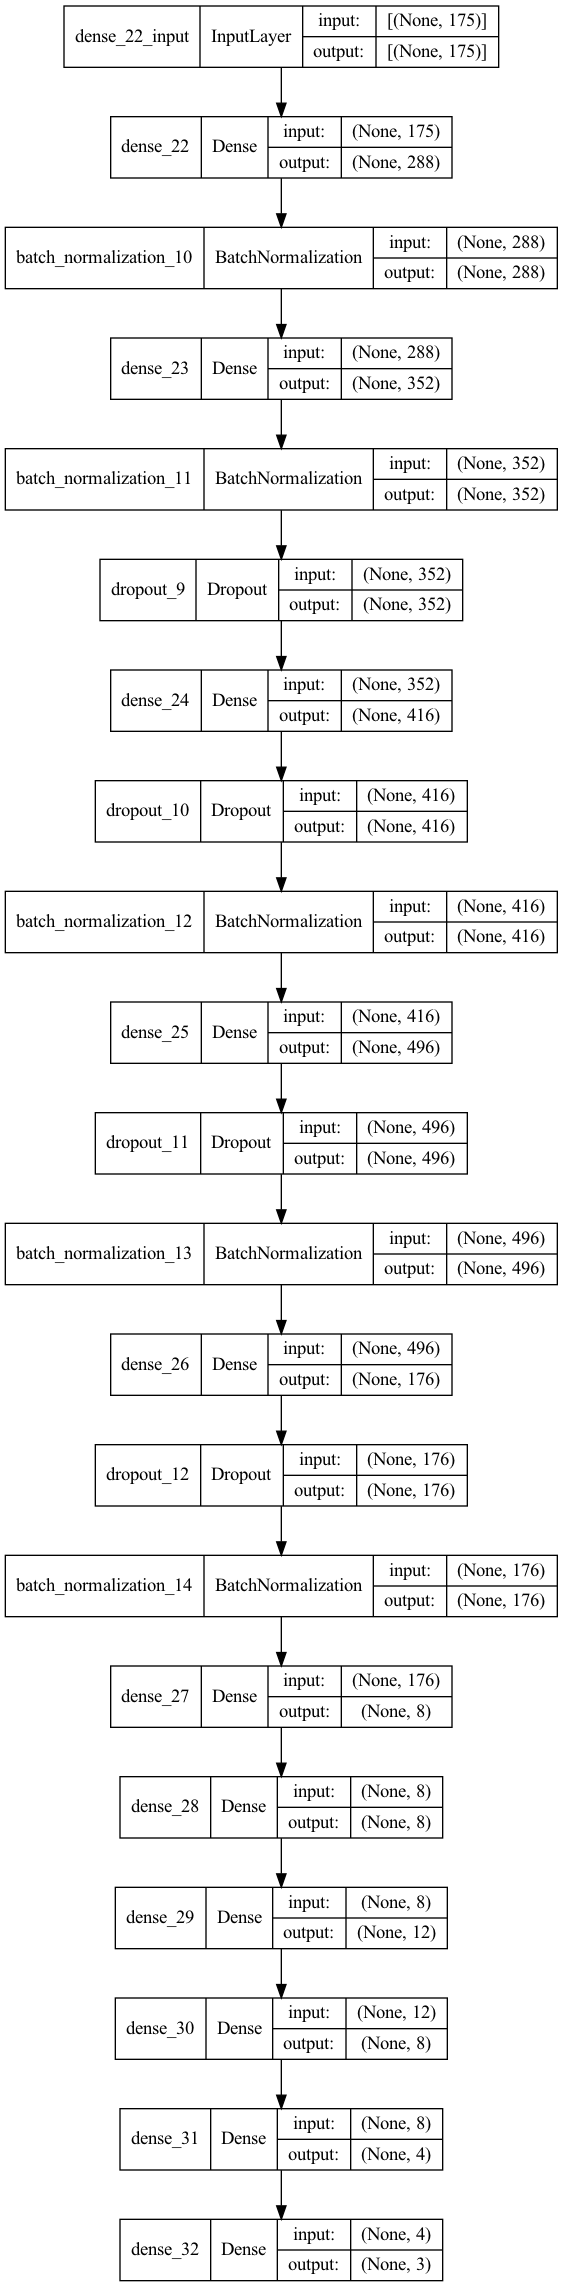

In [15]:
# Print Model Layout:
plot_model(hypermodel, to_file='results/hypermodel_class_withoutTA.png', show_shapes=True)

In [16]:
eval_result = hypermodel.evaluate(X_test, y_test_class)
print("[test loss, test sparse_categorical_crossentropy,test accuracy]:", eval_result)

874/874 [==============================] - 1s 1ms/step - loss: 0.4044 - sparse_categorical_crossentropy: 0.4044 - accuracy: 0.8423
[test loss, test sparse_categorical_crossentropy,test accuracy]: [0.4044002294540405, 0.4044002294540405, 0.8423143029212952]


# 10-Fold Cross-Validation

In [18]:
# Define the K-fold Cross Validator


num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
scores = []


inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train_class, y_test_class), axis=0)

for train, test in kfold.split(inputs, targets):

    best_model = tuner.hypermodel.build(best_hps)

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    best_model.fit(inputs[train], targets[train], epochs=best_epoch, verbose=0, callbacks = [stop_early])
    score = model.evaluate(inputs[test], targets[test], verbose=0)

    y_pred =  best_model.predict(inputs[test], verbose=0)

    prediction_class = []
    for i in range(len(y_pred)):
        if y_pred[i][0] > y_pred[i][1] and y_pred[i][0] > y_pred[i][2]:
            prediction_class.append(0)
        if y_pred[i][1] > y_pred[i][0] and y_pred[i][1] > y_pred[i][2]:
            prediction_class.append(1)
        if y_pred[i][2] > y_pred[i][0] and y_pred[i][2] > y_pred[i][1]:
            prediction_class.append(2)

    score.append(cohen_kappa_score(targets[test], prediction_class))
    print(f'Score [test loss, test sparse_categorical_crossentropy,test accuracy] for fold {fold_no}: {score}')

    #yhat = model.predict(inputs[test])
    #print('MAE: %.3f' % mean_absolute_error(targets[test], yhat))

    #MAE_per_fold.append(mean_absolute_error(targets[test], yhat))
    #loss_per_fold.append(score)
    scores.append(score)
    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Score [test loss, test sparse_categorical_crossentropy,test accuracy] for fold 1: [0.47259122133255005, 0.47259122133255005, 0.8799914121627808, 0.771894020085788]
------------------------------------------------------------------------
Training for fold 2 ...
Score [test loss, test sparse_categorical_crossentropy,test accuracy] for fold 2: [0.4503626525402069, 0.4503626525402069, 0.8819951415061951, 0.76740303513338]
------------------------------------------------------------------------
Training for fold 3 ...
Score [test loss, test sparse_categorical_crossentropy,test accuracy] for fold 3: [0.4747663140296936, 0.4747663140296936, 0.8802061080932617, 0.7684934179315118]
------------------------------------------------------------------------
Training for fold 4 ...
Score [test loss, test sparse_categorical_crossentropy,test accuracy] for fold 4: [0.47283947467803955, 0.47283947467803955,

# Plot Results

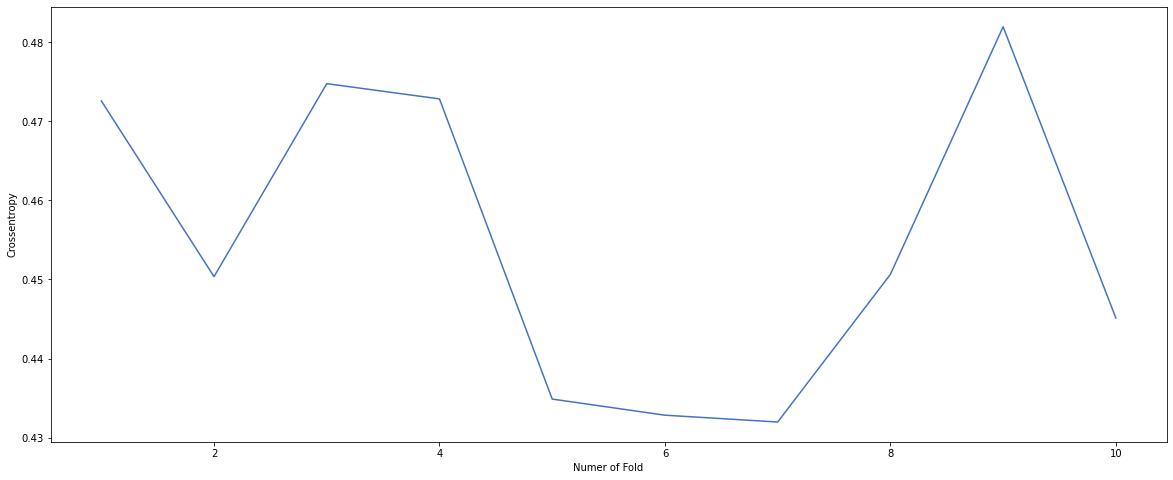

In [19]:
plt.figure(figsize=(20, 8))
#Create the plots
sparse_categorical_crossentropy = []
accuracy = []
cohen = []

for a_tuple in scores:
    sparse_categorical_crossentropy.append(a_tuple[1])
    accuracy.append(a_tuple[2])
    cohen.append(a_tuple[-1])

#plt.plot(range(1,len(scores)+1),accuracy, color='blue', label = 'accuracy')
plt.plot(range(1,len(scores)+1),sparse_categorical_crossentropy, color = '#4472C4', label = 'sparse_categorical_crossentropy')
#Create the title, axis description and legend
#plt.title('Results KFOLD Cross-Validation')
plt.ylabel('Crossentropy')
plt.xlabel("Numer of Fold")
#plt.legend()
#plt.grid()
plt.savefig('results/DNN_KFold_Crossentropy_withoutTA.png')
plt.xticks(rotation = 0)
plt.rcParams.update({'font.size': 12})

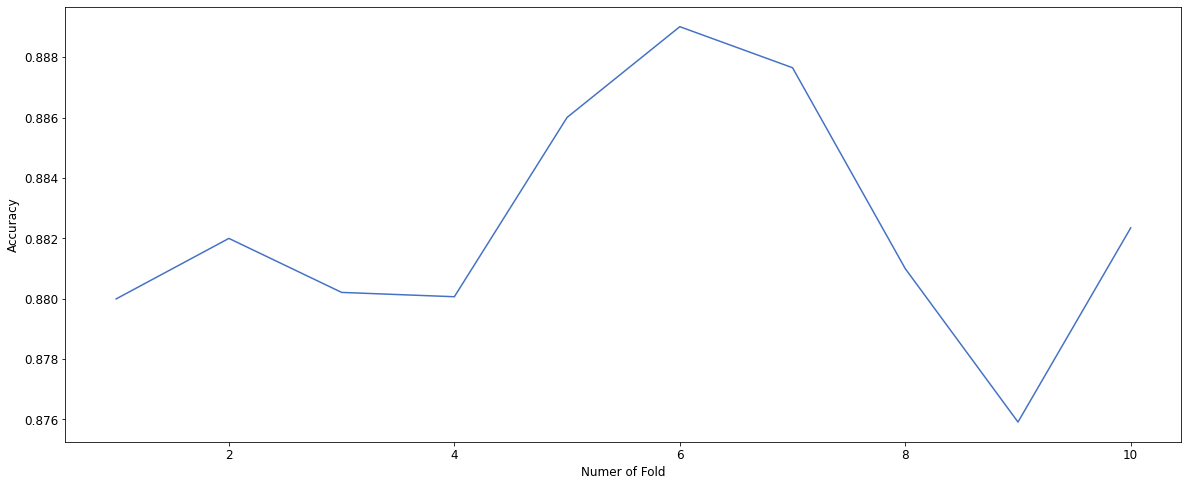

In [20]:
plt.figure(figsize=(20, 8))
plt.plot(range(1,len(scores)+1),accuracy, color = '#4472C4', label = 'accuracy')
#plt.plot(range(1,len(scores)+1),sparse_categorical_crossentropy, color='red', label = 'sparse_categorical_crossentropy')
#Create the title, axis description and legend
#plt.title('Results KFOLD Cross-Validation')
plt.ylabel('Accuracy')
plt.xlabel("Numer of Fold")
#plt.legend()
#plt.grid()
plt.savefig('results/DNN_KFold_Accuracy_withoutTA.png')
plt.xticks(rotation = 0)
plt.rcParams.update({'font.size': 12})

In [21]:
statistics.mean(accuracy)

0.8824165105819702

In [22]:
statistics.mean(cohen)

0.7727546813090774